In [1]:
import numpy as np
def bootstrap_ci(y_test, y_pred, calculate_metric, confidence=0.9, n_resamples=1000, sample_fraction=0.95, random_state=None):
    """
    Compute bootstrap confidence interval for a metric function.
    Parameters:
    - y_test: array-like, true labels.
    - y_pred: array-like, predicted labels.
    - calculate_metric: function, computes the metric given y_test and y_pred.
    - confidence: float, confidence level (default 0.9).
    - n_resamples: int, number of bootstrap resamples (default 100).
    - sample_fraction: float, fraction of data to sample in each resample (default 0.95).
    - random_state: int or None, random seed for reproducibility.
    Returns:
    - (lower_bound, upper_bound): tuple of floats, confidence interval bounds.
    """
    rng = np.random.default_rng(random_state)
    n = len(y_test)
    sample_size = int(n * sample_fraction)
    metrics = []
    for _ in range(n_resamples):
        indices = rng.choice(n, size=sample_size, replace=True)
        metric = calculate_metric(np.array(y_test)[indices], np.array(y_pred)[indices])
        metrics.append(metric)
    alpha = (1 - confidence) / 2
    lower = np.percentile(metrics, 100 * alpha)
    upper = np.percentile(metrics, 100 * (1 - alpha))
    return {"metric": round(calculate_metric(y_test, y_pred), 4), "confidence_interval": (round(lower, 4), round(upper, 4))}

# def calculate_metric(y_true, y_pred):
#     # Example: Mean Absolute Error
#     return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
# y_test = [1, 2, 3, 4, 5]
# y_pred = [1.1, 1.9, 3.2, 3.8, 5.1]

# print(bootstrap_ci(y_test, y_pred, calculate_metric, confidence=0.9))


# # Evaluate the model
# predictions = trainer.predict(tokenized_test_dataset)
# preds = np.argmax(predictions.predictions, axis=-1)
# true_labels = predictions.label_ids

# # Generate detailed classification report (using integer labels)
# print("Detailed Classification Report (Integer Labels):")
# print(classification_report(true_labels, preds, digits=4))

# # Generate classification report with target names (map back to original string labels)
# target_names = [id_to_label[i] for i in range(len(label_list))]
# print("Detailed Classification Report (String Labels):")
# print(classification_report(true_labels, preds, target_names=target_names, digits=4))

# def accuracy_metric(y_true, y_pred):
#     return np.mean(y_true == y_pred)
# bootstrap_ci(true_labels, preds, accuracy_metric)

## Train

In [5]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your dataset and drop rows with missing responses
df = pd.read_csv("./mrbench_v3_devset_train_data.csv").dropna(subset=["response"])

# Convert string labels to integer indices
# Create mapping dictionaries for encoding and later decoding
label_list = sorted(df["label"].unique())
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Replace string labels with integer labels in the DataFrame
df["label"] = df["label"].map(label_to_id)

# Split by conversation_id
conversation_ids = df["conversation_id"].unique()
train_ids, test_ids = train_test_split(conversation_ids, test_size=0.2, random_state=42)

train_df = df[df["conversation_id"].isin(train_ids)].reset_index(drop=True)
test_df = df[df["conversation_id"].isin(test_ids)].reset_index(drop=True)

# train_texts = [f"{c} [SEP] {r}" for c, r in zip(train_df["conversation_history"].tolist(), train_df["response"].tolist())]
# test_texts = [f"{c} [SEP] {r}" for c, r in zip(test_df["conversation_history"].tolist(), test_df["response"].tolist())]

train_texts = [f"{c} [SEP] {r}" for c, r in zip(train_df["conversation_history"].tolist(), train_df["response"].tolist())]
test_texts = [f"{c} [SEP] {r}" for c, r in zip(test_df["conversation_history"].tolist(), test_df["response"].tolist())]


train_dataset = Dataset.from_dict({"text": train_texts, "label": train_df["label"].tolist()})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_df["label"].tolist()})

# Initialize tokenizer & model
model_name = "tbs17/MathBERT" #"bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))
model.to(device)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Compute metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # evaluates at the end of each epoch
    save_strategy="epoch",          # saves checkpoint at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
torch.cuda.empty_cache()
trainer.train()

# Evaluate the model
predictions = trainer.predict(tokenized_test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Generate classification report with target names (map back to original string labels)
target_names = [id_to_label[i] for i in range(len(label_list))]
print("Detailed Classification Report (String Labels):")
print(classification_report(true_labels, preds, target_names=target_names, digits=4))

# --- Save the Fine-tuned Model ---
# Before saving, update the model configuration with label mappings so that id2label and label2id
# are stored in the saved config.json. This is necessary because categorical labels are not handled by default.
model.config.id2label = id_to_label
model.config.label2id = label_to_id

# Save the model and tokenizer; the config will be saved automatically
save_directory = "./saved_model_mathbert"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tbs17/MathBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 415/415 [00:01<00:00, 212.56 examples/s]
/var/tmp/ipykernel_13247/1827430558.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,No log,0.979549,0.696386,0.686922
2,1.612600,0.778208,0.746988,0.742695
3,0.557600,0.742567,0.795181,0.798060
4,0.245900,0.842774,0.792771,0.785818
5,0.098400,0.864112,0.797590,0.791224


Detailed Classification Report (String Labels):
              precision    recall  f1-score   support

      Expert     0.7458    0.8800    0.8073        50
        GPT4     0.8077    0.8400    0.8235        50
      Gemini     0.8776    0.8600    0.8687        50
 Llama31405B     0.8049    0.6600    0.7253        50
   Llama318B     0.6667    0.6400    0.6531        50
     Mistral     0.8125    0.7800    0.7959        50
      Novice     0.7333    0.7333    0.7333        15
        Phi3     0.8571    0.8400    0.8485        50
      Sonnet     0.8333    0.9000    0.8654        50

    accuracy                         0.7976       415
   macro avg     0.7932    0.7926    0.7912       415
weighted avg     0.7983    0.7976    0.7961       415

Model and tokenizer saved to ./saved_model_mathbert


In [ ]:
import json
with open("./mrbench_v3_testset.json", "r") as f:
    test_set_json = json.load(f)

data = []
for entry in test_set_json:
    for key in entry["tutor_responses"]:
        data.append([entry["conversation_id"], entry["conversation_history"], key, entry["tutor_responses"][key]["response"]])
df = pd.DataFrame(data, columns=["conversation_id", "conversation_history", "tutor_id", "tutor_response"])

with open("./saved_model/config.json", "r") as f:
    id2label = json.load(f)["id2label"]

# Now make Hugging Face Dataset objects manually
test_texts = [f"{c} </s> <s> {r} </s>" for c, r in zip(df["conversation_history"].tolist(), df["tutor_response"].tolist())]
test_dataset = Dataset.from_dict({"text": test_texts, "label": [0] * len(test_texts)})
print(test_texts[:2])

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=1024
    )

tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Run predictions
predictions = trainer.predict(tokenized_test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Map prediction indices to labels
pred_labels = [id2label[str(label)] for label in preds]

# Add predictions to the DataFrame for inspection
df["predicted_label"] = pred_labels

# df.groupby(["conversation_id", "conversation_history"]).apply(lambda x: )

with open("./saved_model/predictions.json", "w") as f:
    json.dump(df.groupby(["conversation_id", "conversation_history"], sort=False).apply(
        lambda group: {
            "conversation_id": group.name[0],
            "conversation_history": group.name[1],
            "tutor_responses": {
                f"Tutor_{i+1}": {
                    "response": row["tutor_response"],
                    "annotation": {"Tutor_Identification": row["predicted_label"]}
                }
                for i, row in enumerate(group.to_dict("records"))
            }
        }
    ).tolist(), f)

In [16]:
output_df = pd.DataFrame({"text": test_texts, "pred": [id_to_label[x] for x in preds], "true_label": [id_to_label[x] for x in true_labels]})
output_df = output_df.loc[output_df["pred"] != output_df["true_label"]]
output_df.to_csv("mistakes.csv")

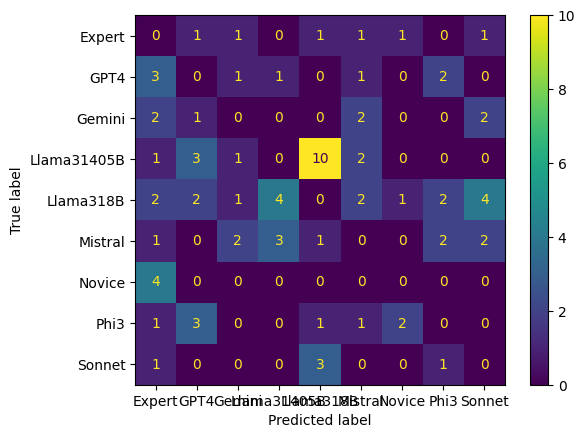

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(output_df["true_label"], output_df["pred"], labels=target_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()
plt.show()

In [19]:
output_df.to_json("mistakes.json", orient="records")